In [32]:
import pandas as pd  # to load and manipulate data for One-Hot-Encoding
import numpy as np  # calculate mean & std
import xgboost as xgb 
from sklearn.model_selection import train_test_split  # to split data in training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import plot_confusion_matrix 
%matplotlib widget
import matplotlib.pyplot as plt 

## import data

In [3]:
df = pd.read_csv("Telco_customer_churn.csv")

# these columns should not be used in model   
df.drop(["Churn Label", "Churn Score", "CLTV", "Churn Reason"], axis=1, inplace=True)

# useless columns due to only contain 1 value
# CustomerID is a random value
# Lat Long is a combination of 2 other columns
df.drop(["Count", "Country", "State", "CustomerID", "Lat Long"], axis=1, inplace=True)

# need to remove whitespace from cities not because of xgboost due to one-hot-encoding 
# takes care of that. But need the whitespaces to draw the decision tree
df["City"].replace(" ", "_", regex=True, inplace=True)

# remove whitespace from column names
df.columns = df.columns.str.replace(" ", "_")

df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


## identifying missing data
* ### unique about xgboost is that it has default behavior for missing data and need to make them 0's 

In [4]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

* ### long story short everything fine except Total Charges

In [5]:
# too many unique values, casting column to a numeric data type
# to check if only contains numbers should do the trick
df["Total_Charges"].unique()

# error occurs. The stacktrace leads to the conclusion that there are blank spaces  
# df["Total Charges"] = df.to_numeric(df["Total Charges"])

array(['108.15', '151.65', '820.5', ..., '7362.9', '346.45', '6844.5'],
      dtype=object)

## dealing with missing data
* ### xgboost style convert missing data to 0's

In [6]:
print("missing data: ", len(df.loc[(df["Total_Charges"] == " ")]))
print("missing data in %: ", len(df.loc[(df["Total_Charges"] == " ")]) / len(df) * 100)
df.loc[(df["Total_Charges"] == " ")]

missing data:  11
missing data in %:  0.1561834445548772


,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


In [7]:
df.loc[(df["Total_Charges"] == " "), "Total_Charges"] = 0

# still need to convert data type due to xgboost only allows 
# int, float or boolean for missing data
df["Total_Charges"] = pd.to_numeric(df["Total_Charges"])

# reason for Total_Charges=" " is when Tenure_Months=0, now data is fine
df.loc[df["Tenure_Months"] == 0, ["Tenure_Months", "Total_Charges"]]

,Tenure_Months,Total_Charges
2234,0,0.0
2438,0,0.0
2568,0,0.0
2667,0,0.0
2856,0,0.0
4331,0,0.0
4687,0,0.0
5104,0,0.0
5719,0,0.0
6772,0,0.0


In [8]:
# replace whitespace for the whole dataframe
df.replace(" ", "_", regex=True, inplace=True)

## split data
* ### by Churn_Value: 1 people left company & 0 did not leave

In [9]:
X = df.drop("Churn_Value", axis=1).copy()
X

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Landers,92285,34.341737,-116.539416,Female,No,No,No,72,Yes,...,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,Yes,Bank_transfer_(automatic),21.15,1419.40
7039,Adelanto,92301,34.667815,-117.536183,Male,No,Yes,Yes,24,Yes,...,No,Yes,Yes,Yes,Yes,One_year,Yes,Mailed_check,84.80,1990.50
7040,Amboy,92304,34.559882,-115.637164,Female,No,Yes,Yes,72,Yes,...,Yes,Yes,No,Yes,Yes,One_year,Yes,Credit_card_(automatic),103.20,7362.90
7041,Angelus_Oaks,92305,34.167800,-116.864330,Female,No,Yes,Yes,11,No,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,29.60,346.45


In [10]:
y = df["Churn_Value"].copy()
y

0       1
1       1
2       1
3       1
4       1
       ..
7038    0
7039    0
7040    0
7041    0
7042    0
Name: Churn_Value, Length: 7043, dtype: int64

## one-hot encoding

In [12]:
# many categorical data
X_encoded = pd.get_dummies(X, columns=["City", "Gender", "Senior_Citizen", "Partner", "Dependents",
                                "Phone_Service", "Multiple_Lines", "Internet_Service", "Online_Security",
                                "Online_Backup", "Device_Protection", "Tech_Support", "Streaming_TV",
                                "Streaming_Movies", "Contract", "Paperless_Billing", "Payment_Method"])
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0


In [13]:
# y is fine, only has 0's & 1's
y.unique()

array([1, 0], dtype=int64)

## preliminary xgboost model

* Note: using random_state to recreate same model
* ### problem: imbalance in y. Way more people who stayed at the company than leaving (27%)

In [14]:
print(sum(y) / len(y))

0.2653698707936959


* ### need to maintain percentage in training and testing data set<br>that means using stratification in splitting

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

# in train & test same percentage
print(sum(y_train) / len(y_train))
print(sum(y_test) / len(y_test))

0.2654297614539947
0.26519023282226006


In [22]:
# missing: how to deal with missing values, None is the default which basically means 0/np.nan 
# use_label_encoder=False necessary to prevent a Userwarning but code would still work without it
clf_xgb = xgb.XGBClassifier(objective="binary:logistic", missing=0, seed=42, use_label_encoder=False)
clf_xgb.fit(X_train, y_train,
            verbose=True,  # printing results
            early_stopping_rounds=10,   # stops when the next 10 trees does not give a better prediction
            eval_metric="aucpr",  # method how to evaluate the predictions
            eval_set=[(X_test, y_test)])  # uses the training set to evaluate how many trees to build

[0]	validation_0-aucpr:0.64036
[1]	validation_0-aucpr:0.64414
[2]	validation_0-aucpr:0.65129
[3]	validation_0-aucpr:0.65054
[4]	validation_0-aucpr:0.65323
[5]	validation_0-aucpr:0.64855
[6]	validation_0-aucpr:0.65460
[7]	validation_0-aucpr:0.65895
[8]	validation_0-aucpr:0.65746
[9]	validation_0-aucpr:0.65851
[10]	validation_0-aucpr:0.66217
[11]	validation_0-aucpr:0.66528
[12]	validation_0-aucpr:0.66322
[13]	validation_0-aucpr:0.66310
[14]	validation_0-aucpr:0.66001
[15]	validation_0-aucpr:0.66028
[16]	validation_0-aucpr:0.65781
[17]	validation_0-aucpr:0.65590
[18]	validation_0-aucpr:0.65735
[19]	validation_0-aucpr:0.65857
[20]	validation_0-aucpr:0.65896
[21]	validation_0-aucpr:0.65961


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=0, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

* ### did not classify good weather people leaving company, due to imbalance in data set

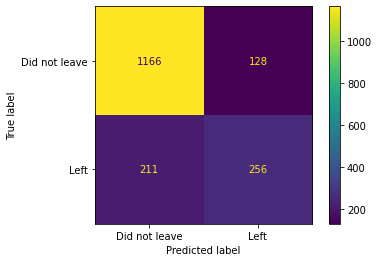

In [25]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format="d", display_labels=["Did not leave", "Left"])
plt.show()

## optimize xgboost with cross validation & gridsearch
* ### xgboost has parameter scale_pos_weight which helps dealing with imbalanced data<br>giving the minority class a higher weight, meaning a punishment if classified wrong<br><br>

* ### GridSearchCV to optimize hyperparameters:
* * ### max_depth: maximum tree depth
* * ### learning rate eta
* * ### gamma: encourages pruning
* * ### lambda: regulation parameter for ridge regression<br><br>

* ### Note: the code below takes some time
* ### output: gamma=0.25, learn_rate=0.1, max_depth=4 & reg_lambda=10

In [ ]:
# using AUC for evaluation & optimize scale_per_weight is recommended

# round 1
# param_grid = {max_depth: [3, 4, 5], "learning rate": [0.1, 0.05, 0.01], "gamma": [0, 0.25, 1.0], 
#                 "reg_lambda": [0, 1.0, 10.0], "scale_pos_weight": [1, 3, 5]}
# output: max_depth = 4, learning_rate = 0.1, gamma = 0.25, reg_lambda = 10, scale_pos_weight = 3
# because learning rate and reg_lambda were end of their range, explore more

# round 2
# param_grid = {max_depth: [4], "learning rate": [0.1, 0.5, 1.0], "gamma": [0.25], 
#                 "reg_lambda": [10.0, 20.0, 100.0], "scale_pos_weight": [3]}
# output: same as round 1

# to speed things up and prevent overfitting, Using random 
# subset of the data of 90%(rows) and 50%(columns) of the features 
# optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistics", seed = 42, 
#                                                             subsample = 0.9, colsample_bytree = 0.5),
#                                 param_grid=param_grid,
#                                 scoring="roc_auc"
#                                 verbose=0, 
#                                 n_jobs=10, 
#                                 cv=3
#                                 )

# optimal_params.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc", eval_set[(X_test, y_test)],
#                     verbose=False)

# optimal_params.best_params_ 

## final model

In [28]:
clf_xgb = xgb.XGBClassifier(seed=42, objective="binary:logistic", gamma=0.25, learn_rate=0.1,
                            max_depth=4, reg_alpha=10, scale_pos_weight=3, 
                            subsample=0.9, colsample_bytree=0.5, use_label_encoder=False)

clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, 
                eval_metric="aucpr", eval_set=[(X_test, y_test)])

[10:51:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "learn_rate" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.56964
[1]	validation_0-aucpr:0.59968
[2]	validation_0-aucpr:0.62882
[3]	validation_0-aucpr:0.63321
[4]	validation_0-aucpr:0.63728
[5]	validation_0-aucpr:0.63880
[6]	validation_0-aucpr:0.63737
[7]	validation_0-aucpr:0.63750
[8]	validation_0-aucpr:0.63859
[9]	validation_0-aucpr:0.64918
[10]	validation_0-aucpr:0.64786
[11]	validation_0-aucpr:0.65517
[12]	validation_0-aucpr:0.65515
[13]	validation_0-aucpr:0.65419
[14]	validation_0-aucpr:0.65884
[15]	validation_0-aucpr:0.66041
[16]	validation_0-aucpr:0.65946
[17]	validation_0-aucpr:0.65823
[18]	validation_0-aucpr:0.65928
[19]	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learn_rate=0.1, learning_rate=0.300000012, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=10, reg_lambda=1,
              scale_pos_weight=3, seed=42, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

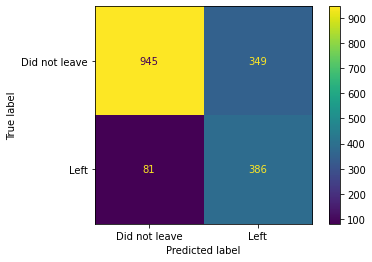

In [29]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format="d", display_labels=["Did not leave", "Left"])
plt.show()

## draw tree
* ### draw and build first tree to see gain and cover, otherwise we would get averages over all the trees

In [ ]:
clf_xgb = xgb.XGBClassifier(seed=42, objective="binary:logistic", gamma=0.25, learn_rate=0.1,
                            max_depth=4, reg_alpha=10, scale_pos_weight=3, subsample=0.9,
                            colsample_bytree=0.5, n_estimators=1) # to 1 - create 1 tree 

clf_xgb.fit(X_train, y_train)

In [38]:
# weight = number of times a features is used in a branch or root across all trees
# gain = the average gain across all splits that the feature is used in
# cover = the average coverage across all splits a feature is used in
# total_gain = the total gain across all the splits the feature is used in
# total_cover = the total coverage across all the splits the feature in used in
# since build only 1 tree: gain = total_gain and cover = total_cover

# printing stuff
bst = clf_xgb.get_booster()
for importance_type in ("weight", "gain", "cover", "total_gain", "total_cover"):
    print("%s: " % importance_type, bst.get_score(importance_type=importance_type))

# design stuff
node_params = {
    "shape": "box",
    "style": "filled, rounded",
    "fillcolor": "#78cbe",
}

leaf_params = {"shape": "box", "style": "filled", "fillcolor": "#e48038"}

# visualizing tree - but this is bad
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_tree(clf_xgb, ax=ax)
fig.show()
fig.savefig("test.jpg")

# # this does a better job at visualizing
# # num_trees=0 is not the number of trees but the tree to plot, meaning the first. Default is 0
graph_data = xgb.to_graphviz(clf_xgb, num_trees=0, size="10, 10", condition_node_params=node_params, 
                        leaf_node_params=leaf_params)
graph_data.format = "png"
graph_data.view(filename="view")

weight:  {'Tech_Support_No': 5, 'Contract_Two_year': 3, 'Internet_Service_Fiber_optic': 8, 'Tenure_Months': 47, 'Latitude': 47, 'City_Cupertino': 1, 'Internet_Service_DSL': 5, 'Contract_One_year': 3, 'Senior_Citizen_No': 3, 'Streaming_Movies_Yes': 5, 'City_San_Jose': 1, 'Paperless_Billing_No': 5, 'Longitude': 36, 'City_Santa_Monica': 1, 'City_Lakewood': 1, 'Contract_Month-to-month': 10, 'Dependents_No': 13, 'Monthly_Charges': 67, 'Online_Security_No': 9, 'Total_Charges': 50, 'Zip_Code': 53, 'Streaming_TV_Yes': 3, 'Payment_Method_Electronic_check': 4, 'City_Running_Springs': 1, 'City_Duarte': 1, 'Streaming_Movies_No': 2, 'Internet_Service_No': 2, 'Dependents_Yes': 5, 'City_Angwin': 1, 'Multiple_Lines_No': 6, 'Partner_Yes': 3, 'Phone_Service_Yes': 2, 'Online_Backup_No': 4, 'Streaming_TV_No': 3, 'Gender_Female': 3, 'Online_Backup_Yes': 3, 'Payment_Method_Mailed_check': 3, 'City_Los_Angeles': 3, 'Partner_No': 7, 'Tech_Support_Yes': 1, 'Paperless_Billing_Yes': 4, 'Device_Protection_Yes': 1,

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

'view.png'